# 3) NeuralBOW & Facebook Fasttext

## Load Dataset and Variables

In [2]:
import pandas as pd
import pickle

In [3]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Model - Facebook Fasttext
[https://arxiv.org/abs/1607.01759](https://arxiv.org/abs/1607.01759)

This is a simple model with a word embedding layer followed by one hidden fully-connected layer. For this model, we'll train our own embeddings with an embedding dimension of 10. By training the embeddings from scratch, we might achieve more tailored embeddings for this particular corpus. We also use our own vocabulary. We'll include all words that appear in the training corpus 3 or more times.

In [31]:
import math
import models.fasttext as fasttext
import numpy as np
import re
import string
import tensorflow as tf

from collections import Counter, defaultdict
from datetime import datetime
from importlib import reload
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

In [10]:
counter = Counter()
stemmer = PorterStemmer()

# manully tokenize the sentences
custom_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", stemmer.stem(word)) for word in words]
    custom_tokenized.append(words)

# count all the tokens
for utterance in custom_tokenized:
    counter.update(word for word in utterance if word not in string.punctuation)

# filter to words of counts greater than 2
vocab = [k for k, v in counter.most_common() if v > 2]

# assign IDs to the words
vocab_word_to_id = defaultdict(lambda: -1)
vocab_id_to_word = {}
for i, word in enumerate(vocab):
    vocab_id_to_word[i] = word
    vocab_word_to_id[word] = i

In [16]:
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)

label_ids = np.array([labels_to_ids[label] for label in labels])
train_x_fasttext = custom_tokenized[:train_cut]
train_y_fasttext = label_ids[:train_cut]
test_x_fasttext = custom_tokenized[train_cut:]
test_y_fasttext = label_ids[train_cut:]

train_x_fasttext = np.array([" ".join(words) for words in train_x_fasttext])
test_x_fasttext = np.array([" ".join(words) for words in test_x_fasttext])

In [23]:
reload(fasttext)
tf.reset_default_graph()
fasttext_model = fasttext.FastText(vocab, num_major_characters, regularize_coef=0.1)

In [28]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./fasttext-board/train")
test_writer = tf.summary.FileWriter("./fasttext-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = fasttext_model.X
    Y = fasttext_model.Y

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_fasttext, train_y_fasttext = shuffle(train_x_fasttext, train_y_fasttext)
        
        for step, x_batch, y_batch in batch_iter(train_x_fasttext, train_y_fasttext, batch_size):
            global_step += 1
            sess.run(fasttext_model.train_op, feed_dict={ X: x_batch, Y: y_batch })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([fasttext_model.accuracy, fasttext_model.merged_summary], feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./fasttext-ckpt/model.ckpt")

2018-12-05 07:06:27.837096 epoch number: 1
test accuracy = 0.1978
2018-12-05 07:06:30.752671 epoch number: 2
test accuracy = 0.1946
2018-12-05 07:06:31.900275 epoch number: 3
test accuracy = 0.1877
2018-12-05 07:06:32.961372 epoch number: 4
test accuracy = 0.1881
2018-12-05 07:06:33.933658 epoch number: 5
test accuracy = 0.1888
2018-12-05 07:06:34.880034 epoch number: 6
test accuracy = 0.1887
2018-12-05 07:06:35.816147 epoch number: 7
test accuracy = 0.1937
2018-12-05 07:06:36.775008 epoch number: 8
test accuracy = 0.1945
2018-12-05 07:06:37.781838 epoch number: 9
test accuracy = 0.2053
2018-12-05 07:06:38.921675 epoch number: 10
test accuracy = 0.2075
2018-12-05 07:06:39.831132 epoch number: 11
test accuracy = 0.2178
2018-12-05 07:06:41.034571 epoch number: 12
test accuracy = 0.2155
2018-12-05 07:06:42.150120 epoch number: 13
test accuracy = 0.2238
2018-12-05 07:06:43.405399 epoch number: 14
test accuracy = 0.2265
2018-12-05 07:06:44.454517 epoch number: 15
test accuracy = 0.2361
2018

This model is only slightly better. It looks like training embeddings from scratch doesn't help.

### FastText Evaluation

INFO:tensorflow:Restoring parameters from ./fasttext-ckpt/model.ckpt
              precision    recall  f1-score   support

      Rachel       0.27      0.48      0.35      1292
        Ross       0.28      0.28      0.28      1290
    Chandler       0.25      0.18      0.21      1173
      Monica       0.23      0.27      0.25      1115
        Joey       0.28      0.29      0.29      1081
      Phoebe       0.28      0.02      0.03       960

   micro avg       0.27      0.27      0.27      6911
   macro avg       0.27      0.25      0.23      6911
weighted avg       0.27      0.27      0.24      6911



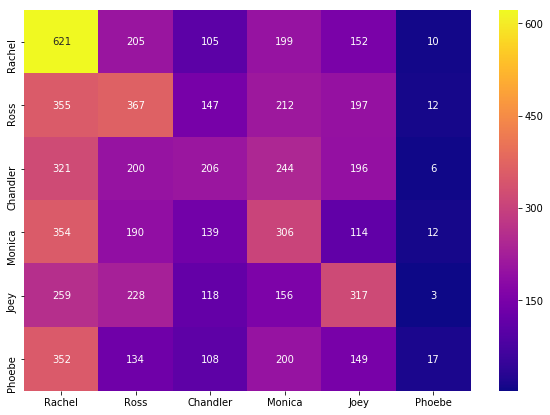

In [32]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./fasttext-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    fasttext_test_preds = sess.run(fasttext_model.predictions, feed_dict={ fasttext_model.X: test_x_fasttext })
    
print(classification_report(test_y_fasttext, fasttext_test_preds, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_fasttext, fasttext_test_preds), major_characters)